# Improving Evolving Hockey's Expected Goals Model

In this script, I will be testing some of my hypotheses about the design of [Evolving Hockey's expected goals model](https://evolving-hockey.com/blog/a-new-expected-goals-model-for-predicting-goals-in-the-nhl/). For simplicity and to save training time, the models are only compared at even strength and a single set of parameters will be used throughout the analysis. These will be estimated from the highest performing parameter combinations, found during the random parameter search in the [analysis of Evolving Hockey's model](evolving_hockey_xg_model.ipynb).

## Effect of the "Shot Type" Boolean
As mentioned in that analysis, the "shot type boolean" features are implicitly encoding whether the shot misses the net. The effect on performance is tested here by removing these booleans. As expected, the performance drops significantly. Therefore, this version will be considered the new baseline, and subsequent alterations of the model will be tested against it.

## Effect of Combining Features
I believe many of the features in this model can be simplified. For example, the "period" and "period time" features should be combinable into a single "game time" feature. Additionally, several boolean features seem redundant. Rather than separating the game score into nine different boolean features, the score will be represented as a discrete "team lead" feature. Similarly, the game state booleans (i.e. "5v5, "4v4", etc...) can be replaced by features denoting the number of players on the ice for each team, and a boolean indicating whether the goalie has been pulled. Lastly, the prior event type booleans are separated into same/opponent team categories in the Evolving Hockey model. I think these can be reduced by half by including a single same_team_last boolean. If I am correct, these changes will not affect the performance of the model. 

## Effect of Removing Features
Evolving Hockey simply included all possible features into their model, in an effort to maximize the model's performance. However, including all possible data can actually be counter productive in some cases. It may increase the signal to noise ratio, lead to overfitting, and even reduce the model performance in some situations. Therefore, in order to determine whether there are redundant features in the model, features are removed in sequence and the changes in performance and calibration are compared. 

## Effect of Adding Features
Evolving Hockey only used information available in the play-by-play data from the [NHL's RTSS data](http://www.nhl.com/scores/htmlreports/20172018/PL020672.HTM). However, I think including information about the players could improve the performance of the model. In particular, if defenders and forwards have different levels of scoring ability, using the shooter position as a boolean should improve model performance. I think it also may be informative to know if the previous play was a turnover in the attacking end, as this can quickly lead to a high danger scoring opportunity.

## Effect of Shuffling the Data
The original Evolving Hockey model uses a single season of data to test, and several seasons leading up to that seaason for training. Shuffling the data has a fairly significant positive impact on the model's performance. Shuffling reduces bias associated with time series sampling, for example scoring patterns changes from season to season, or when the data comes from different sources. However, it is not completely clear why the effect of shuffling is so strong. 

## Effect of Using Less Data
Interestingly, Evolving Hockey chose to use less data than what they had available. The blog about their model was written after the 2020-21 season, but they chose to only use data up to the 2016-17 season for training, and tested on the 2017-18 season. After comparing this dataset to the full dataset (up to 2021-22), it is clear that some changes in the data result in better performance when using the reduced subset. This may indicate a fundamental change in the way goals are scored in the NHL from the year 2017-18 on, which may be why shuffling produces such a strong improvement in performance.

## Effect of Weighting Recent Data More Heavily
If scoring patterns in the NHL change over time, affecting the ability of the model to predict goal probabilities, it makes sense to weight recent samples more heavily. To this end, I fit an exponential curve to the average goals per game data over the training data seasons. This function is then used to weight data points from each season in training the XGBoost model. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from datetime import timedelta, datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from xgboost import XGBClassifier

from models.common_sql import create_db_connection, select_table, sql_select
from models.common_plot import plot_calibration_curves
from models.common_torch import RegressionNN, CustomDataset, train_loop
from nhl_api.ref_common import game_time_to_sec


In [2]:
def split_train_test_sets(all_data, cont_feats, bool_feats, test_season=2021, shuffle=False):
    """ Split the data into training and test sets.
    
    Select the required features, split the data into training and test sets,
    and scale the continuous features.
    
    Parameters
        all_data: dataframe = all of the data used to train and test the model
        cont_feats: list = input columns containing continuous features
        bool_feats: list = input columns containing boolean features
        test_season: int = season to use for testing (all prior seasons used for training)
        shuffle: bool = whether to split the data by randomly shuffling it
        
    Returns
        train_set: array = training data (samples, features)
        test_set: array = test data (samples, features)
        targ_train: array = training labels (samples)
        targ_test: array = test labels (samples)
    """
    input_cols = cont_feats + bool_feats + ['goal']

    # Split the data into stratified training and test sets
    if shuffle:
        all_data = all_data[input_cols]
        X_pd, y_pd = all_data.iloc[:, :-1].values, all_data.iloc[:, -1].values
        tmp_split = train_test_split(X_pd, y_pd, test_size=0.15, random_state=66,
                                     stratify=y_pd)
        train_set, test_set, targ_train, targ_test = tmp_split
    else:
        train_df = all_data[all_data.season < test_season][input_cols]
        train_set, targ_train = train_df.iloc[:, :-1].values, train_df.iloc[:, -1].values
        test_df = all_data[all_data.season == test_season][input_cols]
        test_set, targ_test = test_df.iloc[:, :-1].values, test_df.iloc[:, -1].values

    # Scale the data
    n_cont_col = len(cont_feats)
    x_scaler = MinMaxScaler()
    X_train_norm = x_scaler.fit_transform(train_set[:, :n_cont_col])
    train_set[:, :n_cont_col] = X_train_norm
    X_test_norm = x_scaler.transform(test_set[:, :n_cont_col])
    test_set[:, :n_cont_col] = X_test_norm
    
    return train_set, test_set, targ_train, targ_test


In [3]:
# Create the database connection
connection = create_db_connection('postgres', 'marshineer', 'localhost', '5432', 'password')

# Load and sort the shots data
shots_df = select_table(connection, 'shots')
shots_df.sort_values(['game_id', 'shot_id'], inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Load the player data as a dictionary
players_df = select_table(connection, 'players')
players_list = players_df.to_dict('records')
players = {player_x['player_id']: player_x for player_x in players_list}


# Preprocessing and Feature Selection


In [4]:
# Remove rows where the shift data contained errors
too_few_players = shots_df[shots_df.players_home.apply(lambda x: len(eval(x)) < 4) & shots_df.players_away.apply(lambda x: len(eval(x)) < 4)]
too_many_players = shots_df[shots_df.players_home.apply(lambda x: len(eval(x)) > 6) | shots_df.players_away.apply(lambda x: len(eval(x)) > 6)]
print(f'Number of shift error entries = {len(too_few_players) + len(too_many_players)} '
      f'({100 * (len(too_few_players) + len(too_many_players)) / len(shots_df):4.2f}% of all shots)')
shots_df = shots_df[shots_df.players_home.apply(lambda x: len(eval(x)) >= 4) & shots_df.players_away.apply(lambda x: len(eval(x)) >= 4) & 
                    shots_df.players_home.apply(lambda x: len(eval(x)) <= 6) & shots_df.players_away.apply(lambda x: len(eval(x)) <= 6)]

# Remove rows with nan/null shot distance or angle
null_mask = shots_df.net_distance.isna() | shots_df.net_angle.isna()
print(f'Number of shots with no distance info = {len(shots_df[null_mask])} ({100 * sum(null_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.dropna(subset=['net_distance', 'net_angle'], inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove rows with nan/null previous shot coordinates
null_prev_mask = shots_df.angle_change.isna() | shots_df.delta_x.isna() | shots_df.delta_y.isna()
print(f'Number of shots with no previous event location info = {len(shots_df[null_prev_mask])} '
      f'({100 * sum(null_prev_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.dropna(subset=['angle_change', 'delta_x', 'delta_y'], inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove blocks
block_mask = shots_df.shot_result == 'BLOCK'
blocks_df = shots_df.loc[block_mask]
blocks_df.reset_index(drop=True, inplace=True)
block_list = blocks_df.to_dict('records')
thru_prob = 1 - (sum(block_mask) / len(shots_df))  # Assumes all shots have an equal chance of being blocked
print(f'Number of shots that are blocked = {len(block_mask)} ({100 * (1 - thru_prob):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[block_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove shots made by goalies
goalie_mask = shots_df.shooter_position == 'G'
print(f'Number of shots by goalies = {sum(goalie_mask)} ({100 * sum(goalie_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[goalie_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Create shot type booleans
shots_df['wrist_shot'] = [1 if x == 'WRIST' else 0 for x in shots_df.shot_type]
shots_df['backhand_shot'] = [1 if x == 'BACKHAND' else 0 for x in shots_df.shot_type]
shots_df['slap_shot'] = [1 if x == 'SLAP' else 0 for x in shots_df.shot_type]
shots_df['tip_shot'] = [1 if x == 'TIP' else 0 for x in shots_df.shot_type]
shots_df['deflect_shot'] = [1 if x == 'DEFLECT' else 0 for x in shots_df.shot_type]
shots_df['snap_shot'] = [1 if x == 'SNAP' else 0 for x in shots_df.shot_type]
shots_df['wrap_shot'] = [1 if x == 'WRAP' else 0 for x in shots_df.shot_type]
shots_df['other_shot'] = [1 if x == 'OTHER' else 0 for x in shots_df.shot_type]

# Convert the shots to a list
shot_list = shots_df.to_dict('records')


Number of shift error entries = 735 (0.04% of all shots)
Number of shots with no distance info = 28 (0.00% of all shots)
Number of shots with no previous event location info = 799 (0.05% of all shots)
Number of shots that are blocked = 1687046 (25.19% of all shots)
Number of shots by goalies = 62 (0.00% of all shots)


In [5]:
new_feats = {'5v5': 0,
             '4v4': 0,
             '3v3': 0,
             'score_down_4': 0,
             'score_down_3': 0,
             'score_down_2': 0,
             'score_down_1': 0,
             'score_up_4': 0,
             'score_up_3': 0,
             'score_up_2': 0,
             'score_up_1': 0,
             'score_even': 0,
             'prior_shot_same': 0,
             'prior_miss_same': 0,
             'prior_block_same': 0,
             'prior_give_same': 0,
             'prior_take_same': 0,
             'prior_hit_same': 0,
             'prior_shot_opp': 0,
             'prior_miss_opp': 0,
             'prior_block_opp': 0,
             'prior_give_opp': 0,
             'prior_take_opp': 0,
             'prior_hit_opp': 0,
             'prior_faceoff': 0,
             'prior_shot': 0,
             'prior_miss': 0,
             'prior_block': 0,
             'prior_give': 0,
             'prior_take': 0,
             'prior_hit': 0}


In [6]:
print(shots_df.columns.tolist())

['game_id', 'shot_id', 'shooter_id', 'assist1_id', 'assist2_id', 'shot_type', 'shot_result', 'period', 'period_time', 'shot_time', 'home_team_id', 'away_team_id', 'home_score', 'away_score', 'goal_lead_prior', 'home_shots', 'away_shots', 'shot_lead_prior', 'x_coord', 'y_coord', 'net_distance', 'net_angle', 'last_event_type', 'time_since_last', 'last_same_end', 'last_same_team', 'last_x_coord', 'last_y_coord', 'delta_x', 'delta_y', 'dist_change', 'angle_change', 'last_turnover', 'rebound_shot', 'play_ends', 'puck_frozen', 'goal', 'missed', 'blocked', 'empty_net_goal', 'shooter_home', 'shooter_age', 'shooter_seasons', 'shooter_hand', 'shooter_position', 'off_wing_shot', 'empty_net_home', 'empty_net_away', 'players_home', 'players_away', 'wrist_shot', 'backhand_shot', 'slap_shot', 'tip_shot', 'deflect_shot', 'snap_shot', 'wrap_shot', 'other_shot']


In [7]:
# Extract even strength shots
even_shots = []
for i, shot in enumerate(shot_list):
    # Extract required features
    home_shot = shot['shooter_home']
    n_home = len(eval(shot['players_home']))
    n_away = len(eval(shot['players_away']))
    en_home = shot['empty_net_home']
    en_away = shot['empty_net_away']
    
    # Remove shootout shots
    if shot['period'] > 4 and str(shot['game_id'])[4:6] != '03':
        continue
        
    # Remove empty net shots
    if en_home or en_away:
        continue
        
    # Add a season column
    shot['season'] = int(str(shot['game_id'])[:4])
        
    # Convert period time to seconds (int)
    shot['period_sec'] = game_time_to_sec(shot['period_time'])
    
    # Add new feature keys
    shot.update(new_feats.copy())
    
    # Calculate prior event booleans
    if shot['last_same_team']:
        if shot['last_event_type'] == 'SHOT':
            shot['prior_shot_same'] = 1
        elif shot['last_event_type'] == 'MISS':
            shot['prior_miss_same'] = 1
        elif shot['last_event_type'] == 'BLOCK':
            shot['prior_block_same'] = 1
        elif shot['last_event_type'] == 'GIVEAWAY':
            shot['prior_give_same'] = 1
        elif shot['last_event_type'] == 'TAKEAWAY':
            shot['prior_take_same'] = 1
        elif shot['last_event_type'] == 'HIT':
            shot['prior_hit_same'] = 1
    else:
        if shot['last_event_type'] == 'SHOT':
            shot['prior_shot_opp'] = 1
        elif shot['last_event_type'] == 'MISS':
            shot['prior_miss_opp'] = 1
        elif shot['last_event_type'] == 'BLOCK':
            shot['prior_block_opp'] = 1
        elif shot['last_event_type'] == 'GIVEAWAY':
            shot['prior_give_opp'] = 1
        elif shot['last_event_type'] == 'TAKEAWAY':
            shot['prior_take_opp'] = 1
        elif shot['last_event_type'] == 'HIT':
            shot['prior_hit_opp'] = 1
    # Calculate prior event booleans
    if shot['last_event_type'] == 'SHOT':
        shot['prior_shot'] = 1
    elif shot['last_event_type'] == 'MISS':
        shot['prior_miss'] = 1
    elif shot['last_event_type'] == 'BLOCK':
        shot['prior_block'] = 1
    elif shot['last_event_type'] == 'GIVEAWAY':
        shot['prior_give'] = 1
    elif shot['last_event_type'] == 'TAKEAWAY':
        shot['prior_take'] = 1
    elif shot['last_event_type'] == 'HIT':
        shot['prior_hit'] = 1
    shot['prior_faceoff'] = 1 if shot['last_event_type'] == 'FACEOFF' else 0
    shot['last_same_team'] = 1 if shot['last_same_team'] else 0
    shot['off_wing_shot'] = 1 if shot['off_wing_shot'] else 0
    shot['forward_shot'] = 1 if shot['shooter_position'] == 'F' else 0
    shot['last_turnover_shot_end'] = 1 if shot['last_turnover'] and shot['last_same_end'] else 0
    
    # Calculate lead at time of shot
    if shot['goal_lead_prior'] > 3:
        shot['score_up_4'] = 1
    elif shot['goal_lead_prior'] == 3:
        shot['score_up_3'] = 1
    elif shot['goal_lead_prior'] == 2:
        shot['score_up_2'] = 1
    elif shot['goal_lead_prior'] == 1:
        shot['score_up_1'] = 1
    elif shot['goal_lead_prior'] == 0:
        shot['score_even'] = 1
    elif shot['goal_lead_prior'] == -1:
        shot['score_down_1'] = 1
    elif shot['goal_lead_prior'] == -2:
        shot['score_down_2'] = 1
    elif shot['goal_lead_prior'] == -3:
        shot['score_down_3'] = 1
    elif shot['goal_lead_prior'] < -3:
        shot['score_down_4'] = 1
    shot['team_lead'] = shot['goal_lead_prior']
            
    # Convert target to int
    shot['goal'] = 1 if shot['goal'] else 0
        
    # Add number of players
    shot['n_home_skaters'] = n_home
    shot['n_away_skaters'] = n_away
    
    # Split into game states
    if n_home == n_away:
        if n_home == 6 and n_away == 6:
            shot['5v5'] = 1
        elif n_home == 5 and n_away == 5:
            shot['4v4'] = 1
        elif n_home == 4 and n_away == 4:
            shot['3v3'] = 1
        even_shots.append(shot)


In [8]:
# Convert the even strength shots to a dataframe
data_df = pd.DataFrame(even_shots, columns=list(even_shots[0].keys()))
test_season = 2021

# Calculate the trivial logloss for the game state
p_goal = len(data_df.loc[data_df.goal == True]) / len(data_df)
dumb_loss = -(p_goal * np.log(p_goal) + (1 - p_goal) * np.log(1 - p_goal))
print(f'{100 * p_goal:4.2f}% of {len(data_df)} even strength shots result in a goal (trivial logloss = {dumb_loss:5.4f})')
    

5.74% of 1014131 even strength shots result in a goal (trivial logloss = 0.2199)


In [29]:
# Define an XGB model template
# https://xgboost.readthedocs.io/en/stable/python/python_api.html
xgb_params = {'tree_method': 'hist',
              'use_label_encoder': False,
              'random_state': 68,
              'n_estimators': 200,
              'learning_rate': 0.4,
              'subsample': 0.9,
              'min_child_weight': 5,
              'max_leaves': 25,
              'max_depth': 7,
              'lambda': 10,
              'gamma': 2}


## Baseline Model (Recreation of Evolving Hockey's)

Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.166
Test logloss on the NB model: 0.187
Test accuracy on the NB model: 93.83%


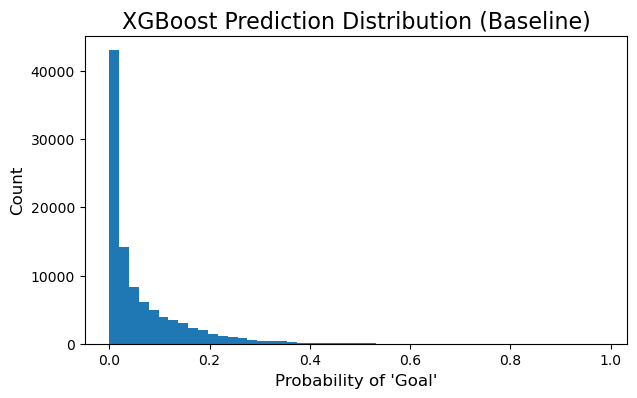

In [30]:
# Define the feature columns
baseline_cont = ['net_distance',  'net_angle', 'period', 'period_sec',
                 'x_coord', 'y_coord', 'last_x_coord', 'last_y_coord',
                 'dist_change', 'time_since_last']
baseline_bool = ['shooter_home', 'wrist_shot', 'backhand_shot', 'slap_shot',
                 'tip_shot', 'deflect_shot', 'snap_shot', 'wrap_shot']

# Extract the training and test data
bool_cols = baseline_bool + list(new_feats.keys())[:-6]
X_train1, X_test1, y_train1, y_test1 = split_train_test_sets(data_df, baseline_cont, bool_cols, test_season=test_season)

xgb_baseline = XGBClassifier(**xgb_params)
xgb_baseline.fit(X_train1, y_train1)
d_baseline = {'name': 'Baseline',
              'y_test': y_test1,
              'model': xgb_baseline}

# Make predictions on the train and test sets
d_baseline['train_loss'] = log_loss(y_train1, d_baseline['model'].predict_proba(X_train1)[:, 1])
d_baseline['test_pred'] = d_baseline['model'].predict_proba(X_test1)[:, 1]
d_baseline['test_loss'] = log_loss(y_test1, d_baseline['test_pred'])
pred_classes = np.round(d_baseline['test_pred'], 0)
d_baseline['test_acc'] = 100 * (pred_classes == y_test1).sum() / y_test1.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(d_baseline['test_pred'], bins=50)
ax.set_title(f"XGBoost Prediction Distribution ({d_baseline['name']})", fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_baseline['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_baseline['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_baseline['test_acc']:4.2f}%")


## No Shot Types

Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.185
Test logloss on the NB model: 0.207
Test accuracy on the NB model: 93.83%


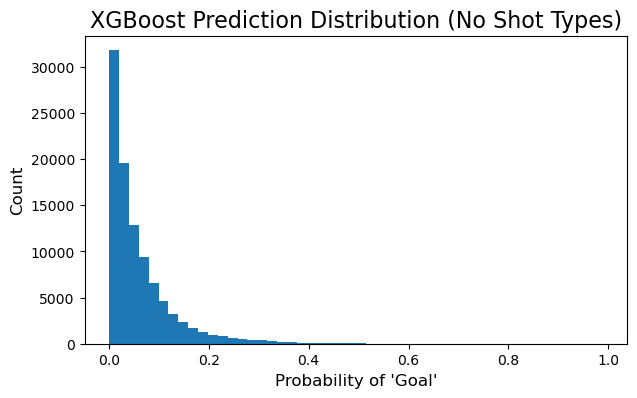

In [31]:
# Define the feature columns
no_shot_type_cont = ['net_distance',  'net_angle', 'period', 'period_sec',
                     'x_coord', 'y_coord', 'last_x_coord', 'last_y_coord',
                     'dist_change', 'time_since_last']
no_shot_type_bool = ['shooter_home']

# Extract the training and test data
bool_cols = no_shot_type_bool + list(new_feats.keys())[:-6]
X_train2, X_test2, y_train2, y_test2 = split_train_test_sets(data_df, no_shot_type_cont, bool_cols, test_season=test_season)

xgb_no_shot_type = XGBClassifier(**xgb_params)
xgb_no_shot_type.fit(X_train2, y_train2)
d_no_shot_type = {'name': 'No Shot Types',
                  'y_test': y_test2,
                  'model': xgb_no_shot_type}

# Make predictions on the train and test sets
d_no_shot_type['train_loss'] = log_loss(y_train2, d_no_shot_type['model'].predict_proba(X_train2)[:, 1])
d_no_shot_type['test_pred'] = d_no_shot_type['model'].predict_proba(X_test2)[:, 1]
d_no_shot_type['test_loss'] = log_loss(y_test2, d_no_shot_type['test_pred'])
pred_classes = np.round(d_no_shot_type['test_pred'], 0)
d_no_shot_type['test_acc'] = 100 * (pred_classes == y_test2).sum() / y_test2.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(d_no_shot_type['test_pred'], bins=50)
ax.set_title(f"XGBoost Prediction Distribution ({d_no_shot_type['name']})", fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_no_shot_type['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_no_shot_type['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_no_shot_type['test_acc']:4.2f}%")


## Combine period and period_time Features

Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.185
Test logloss on the NB model: 0.207
Test accuracy on the NB model: 93.83%


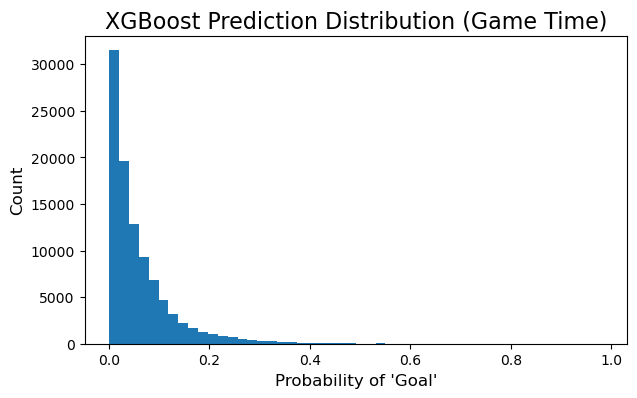

In [32]:
# Define the feature columns
game_time_cont = ['net_distance',  'net_angle', 'shot_time',
                  'x_coord', 'y_coord', 'last_x_coord', 'last_y_coord',
                  'dist_change', 'time_since_last']
game_time_bool = ['shooter_home']

# Extract the training and test data
bool_cols = game_time_bool + list(new_feats.keys())[:-6]
X_train3, X_test3, y_train3, y_test3 = split_train_test_sets(data_df, game_time_cont, bool_cols, test_season=test_season)

xgb_game_time = XGBClassifier(**xgb_params)
xgb_game_time.fit(X_train3, y_train3)
d_game_time = {'name': 'Game Time',
               'y_test': y_test3,
               'model': xgb_game_time}

# Make predictions on the train and test sets
d_game_time['train_loss'] = log_loss(y_train3, d_game_time['model'].predict_proba(X_train3)[:, 1])
d_game_time['test_pred'] = d_game_time['model'].predict_proba(X_test3)[:, 1]
d_game_time['test_loss'] = log_loss(y_test3, d_game_time['test_pred'])
pred_classes = np.round(d_game_time['test_pred'], 0)
d_game_time['test_acc'] = 100 * (pred_classes == y_test3).sum() / y_test3.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(d_game_time['test_pred'], bins=50)
ax.set_title(f"XGBoost Prediction Distribution ({d_game_time['name']})", fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_game_time['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_game_time['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_game_time['test_acc']:4.2f}%")


## Combine Score Booleans into Discrete team_lead

Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.185
Test logloss on the NB model: 0.207
Test accuracy on the NB model: 93.84%


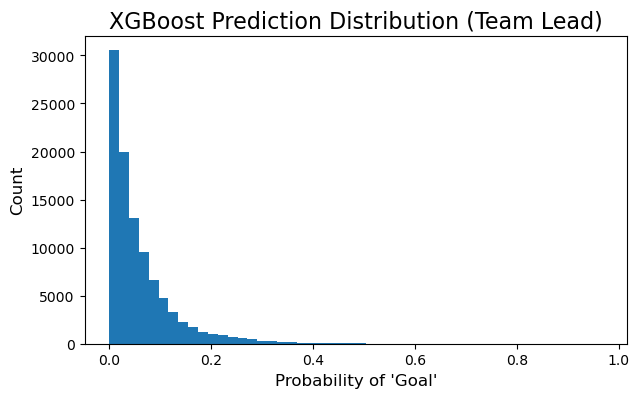

In [33]:
# Define the feature columns
team_lead_cont = ['net_distance',  'net_angle', 'period', 'period_sec',
                  'x_coord', 'y_coord', 'last_x_coord', 'last_y_coord',
                  'dist_change', 'time_since_last', 'team_lead']
team_lead_bool = ['shooter_home']

# Extract the training and test data
bool_cols = team_lead_bool + list(new_feats.keys())[:3] + list(new_feats.keys())[12:-6]
X_train4, X_test4, y_train4, y_test4 = split_train_test_sets(data_df, team_lead_cont, bool_cols, test_season=test_season)

xgb_team_lead = XGBClassifier(**xgb_params)
xgb_team_lead.fit(X_train4, y_train4)
d_team_lead = {'name': 'Team Lead',
               'y_test': y_test4,
               'model': xgb_team_lead}

# Make predictions on the train and test sets
d_team_lead['train_loss'] = log_loss(y_train4, d_team_lead['model'].predict_proba(X_train4)[:, 1])
d_team_lead['test_pred'] = d_team_lead['model'].predict_proba(X_test4)[:, 1]
d_team_lead['test_loss'] = log_loss(y_test4, d_team_lead['test_pred'])
pred_classes = np.round(d_team_lead['test_pred'], 0)
d_team_lead['test_acc'] = 100 * (pred_classes == y_test4).sum() / y_test4.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(d_team_lead['test_pred'], bins=50)
ax.set_title(f"XGBoost Prediction Distribution ({d_team_lead['name']})", fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_team_lead['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_team_lead['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_team_lead['test_acc']:4.2f}%")


## Simplify Prior Event Booleans

Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.186
Test logloss on the NB model: 0.207
Test accuracy on the NB model: 93.82%


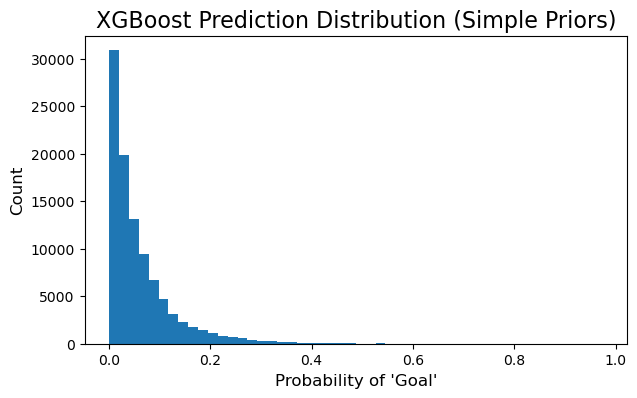

In [34]:
# Define the feature columns
simple_prior_cont = ['net_distance',  'net_angle', 'period', 'period_sec',
                     'x_coord', 'y_coord', 'last_x_coord', 'last_y_coord',
                     'dist_change', 'time_since_last']
simple_prior_bool = ['shooter_home', 'last_same_team']

# Extract the training and test data
bool_cols = simple_prior_bool + list(new_feats.keys())[:12] + list(new_feats.keys())[-7:]
X_train5, X_test5, y_train5, y_test5 = split_train_test_sets(data_df, simple_prior_cont, bool_cols, test_season=test_season)

xgb_simple_prior = XGBClassifier(**xgb_params)
xgb_simple_prior.fit(X_train5, y_train5)
d_simple_prior = {'name': 'Simple Priors',
                  'y_test': y_test5,
                  'model': xgb_simple_prior}

# Make predictions on the train and test sets
d_simple_prior['train_loss'] = log_loss(y_train5, d_simple_prior['model'].predict_proba(X_train5)[:, 1])
d_simple_prior['test_pred'] = d_simple_prior['model'].predict_proba(X_test5)[:, 1]
d_simple_prior['test_loss'] = log_loss(y_test5, d_simple_prior['test_pred'])
pred_classes = np.round(d_simple_prior['test_pred'], 0)
d_simple_prior['test_acc'] = 100 * (pred_classes == y_test5).sum() / y_test5.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(d_simple_prior['test_pred'], bins=50)
ax.set_title(f"XGBoost Prediction Distribution ({d_simple_prior['name']})", fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_simple_prior['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_simple_prior['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_simple_prior['test_acc']:4.2f}%")


## Replace Game State Booleans with Number of Players

Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.185
Test logloss on the NB model: 0.208
Test accuracy on the NB model: 93.83%


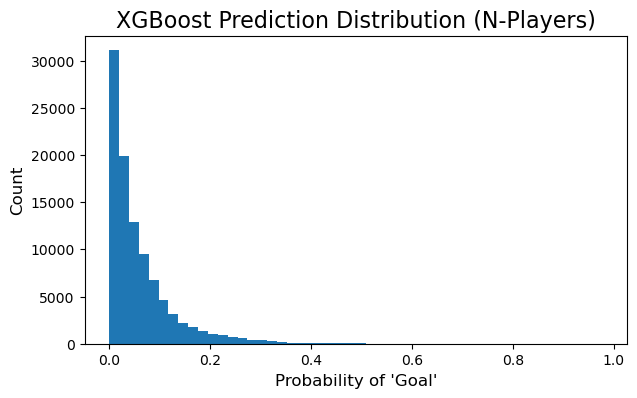

In [35]:
# Define the feature columns
n_players_cont = ['net_distance',  'net_angle', 'period', 'period_sec',
                  'x_coord', 'y_coord', 'last_x_coord', 'last_y_coord',
                  'dist_change', 'time_since_last', 'n_home_skaters',
                  'n_away_skaters']
n_players_bool = ['shooter_home']

# Extract the training and test data
bool_cols = n_players_bool + list(new_feats.keys())[3:-6]
X_train6, X_test6, y_train6, y_test6 = split_train_test_sets(data_df, n_players_cont, bool_cols, test_season=test_season)

xgb_n_players = XGBClassifier(**xgb_params)
xgb_n_players.fit(X_train6, y_train6)
d_n_players = {'name': 'N-Players',
               'y_test': y_test6,
               'model': xgb_n_players}

# Make predictions on the train and test sets
d_n_players['train_loss'] = log_loss(y_train6, d_n_players['model'].predict_proba(X_train6)[:, 1])
d_n_players['test_pred'] = d_n_players['model'].predict_proba(X_test6)[:, 1]
d_n_players['test_loss'] = log_loss(y_test6, d_n_players['test_pred'])
pred_classes = np.round(d_n_players['test_pred'], 0)
d_n_players['test_acc'] = 100 * (pred_classes == y_test6).sum() / y_test6.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(d_n_players['test_pred'], bins=50)
ax.set_title(f"XGBoost Prediction Distribution ({d_n_players['name']})", fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_n_players['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_n_players['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_n_players['test_acc']:4.2f}%")


## Remove Redundant Features

Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.187
Test logloss on the NB model: 0.207
Test accuracy on the NB model: 93.83%


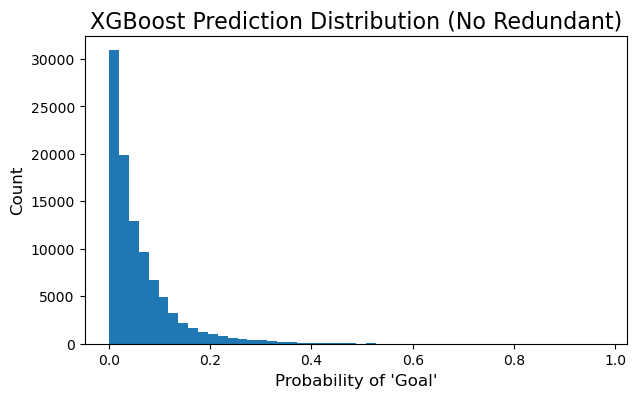

In [36]:
# Define the feature columns
no_redundant_cont = ['net_distance',  'net_angle', 'period', 'period_sec',
                     'dist_change', 'angle_change', 'time_since_last']
no_redundant_bool = ['shooter_home']

# Extract the training and test data
bool_cols = no_redundant_bool + list(new_feats.keys())[:-6]
X_train7, X_test7, y_train7, y_test7 = split_train_test_sets(data_df, no_redundant_cont, bool_cols, test_season=test_season)

xgb_no_redundant = XGBClassifier(**xgb_params)
xgb_no_redundant.fit(X_train7, y_train7)
d_no_redundant = {'name': 'No Redundant',
                  'y_test': y_test7,
                  'model': xgb_no_redundant}

# Make predictions on the train and test sets
d_no_redundant['train_loss'] = log_loss(y_train7, d_no_redundant['model'].predict_proba(X_train7)[:, 1])
d_no_redundant['test_pred'] = d_no_redundant['model'].predict_proba(X_test7)[:, 1]
d_no_redundant['test_loss'] = log_loss(y_test7, d_no_redundant['test_pred'])
pred_classes = np.round(d_no_redundant['test_pred'], 0)
d_no_redundant['test_acc'] = 100 * (pred_classes == y_test7).sum() / y_test7.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(d_no_redundant['test_pred'], bins=50)
ax.set_title(f"XGBoost Prediction Distribution ({d_no_redundant['name']})", fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_no_redundant['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_no_redundant['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_no_redundant['test_acc']:4.2f}%")


## All Simplifications

Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.187
Test logloss on the NB model: 0.207
Test accuracy on the NB model: 93.83%


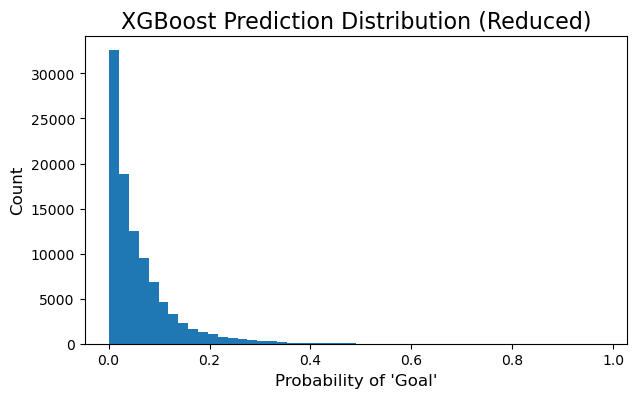

In [37]:
# Define the feature columns
reduced_cont = ['net_distance',  'net_angle', 'dist_change', 'angle_change',
                'shot_time', 'team_lead', 'time_since_last',
                'n_home_skaters', 'n_away_skaters']
reduced_bool = ['shooter_home', 'last_same_team']

# Extract the training and test data
bool_cols = reduced_bool + list(new_feats.keys())[-7:]
X_train8, X_test8, y_train8, y_test8 = split_train_test_sets(data_df, reduced_cont, bool_cols, test_season=test_season)

xgb_reduced = XGBClassifier(**xgb_params)
xgb_reduced.fit(X_train8, y_train8)
d_reduced = {'name': 'Reduced',
             'y_test': y_test8,
             'model': xgb_reduced}

# Make predictions on the train and test sets
d_reduced['train_loss'] = log_loss(y_train8, d_reduced['model'].predict_proba(X_train8)[:, 1])
d_reduced['test_pred'] = d_reduced['model'].predict_proba(X_test8)[:, 1]
d_reduced['test_loss'] = log_loss(y_test8, d_reduced['test_pred'])
pred_classes = np.round(d_reduced['test_pred'], 0)
d_reduced['test_acc'] = 100 * (pred_classes == y_test8).sum() / y_test8.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(d_reduced['test_pred'], bins=50)
ax.set_title(f"XGBoost Prediction Distribution ({d_reduced['name']})", fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_reduced['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_reduced['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_reduced['test_acc']:4.2f}%")


## Add Player Position

Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.185
Test logloss on the NB model: 0.207
Test accuracy on the NB model: 93.83%


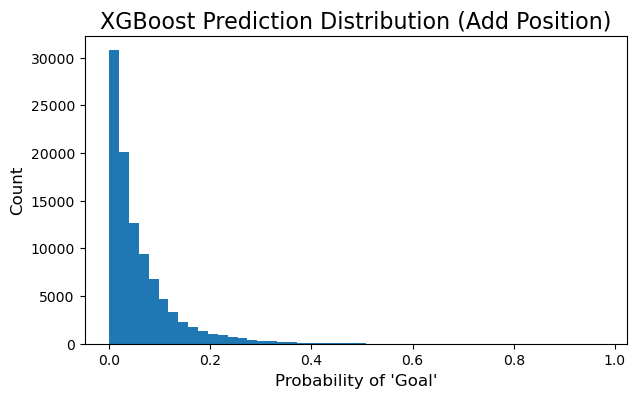

In [38]:
# Define the feature columns
add_pos_cont = ['net_distance',  'net_angle', 'period', 'period_sec',
                'x_coord', 'y_coord', 'last_x_coord', 'last_y_coord',
                'dist_change', 'time_since_last']
add_pos_bool = ['shooter_home', 'forward_shot']

# Extract the training and test data
bool_cols = add_pos_bool + list(new_feats.keys())[:-6]
X_train9, X_test9, y_train9, y_test9 = split_train_test_sets(data_df, add_pos_cont, bool_cols, test_season=test_season)

xgb_add_pos = XGBClassifier(**xgb_params)
xgb_add_pos.fit(X_train9, y_train9)
d_add_pos = {'name': 'Add Position',
             'y_test': y_test9,
             'model': xgb_add_pos}

# Make predictions on the train and test sets
d_add_pos['train_loss'] = log_loss(y_train9, d_add_pos['model'].predict_proba(X_train9)[:, 1])
d_add_pos['test_pred'] = d_add_pos['model'].predict_proba(X_test9)[:, 1]
d_add_pos['test_loss'] = log_loss(y_test9, d_add_pos['test_pred'])
pred_classes = np.round(d_add_pos['test_pred'], 0)
d_add_pos['test_acc'] = 100 * (pred_classes == y_test9).sum() / y_test9.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(d_add_pos['test_pred'], bins=50)
ax.set_title(f"XGBoost Prediction Distribution ({d_add_pos['name']})", fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_add_pos['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_add_pos['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_add_pos['test_acc']:4.2f}%")


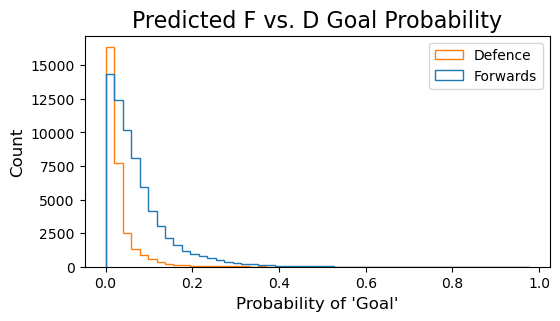

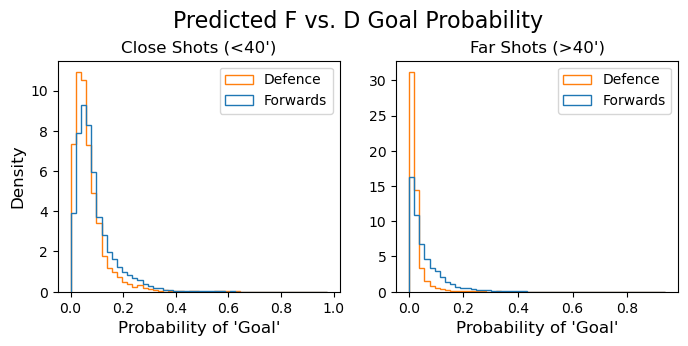

In [39]:
# Demonstrate separation in predictions, due to player position
x_test_df = data_df[data_df.season == test_season]
f_mask = x_test_df.forward_shot == 1
f_test_pred = d_add_pos['test_pred'][f_mask]
d_test_pred = d_add_pos['test_pred'][~f_mask]
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist([f_test_pred, d_test_pred], histtype='step', bins=50, label=['Forwards', 'Defence'])
ax.set_title('Predicted F vs. D Goal Probability', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.legend();

# Check close vs far shots
close_mask = x_test_df.net_distance <= 40
f_close_pred = d_add_pos['test_pred'][f_mask & close_mask]
d_close_pred = d_add_pos['test_pred'][~f_mask & close_mask]
f_far_pred = d_add_pos['test_pred'][f_mask & ~close_mask]
d_far_pred = d_add_pos['test_pred'][~f_mask & ~close_mask]
close_far_data = [[f_close_pred, d_close_pred], [f_far_pred, d_far_pred]]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
for i, (plt_data, plt_ttl) in enumerate(zip(close_far_data, [('Close', '<'), ('Far', '>')])):
    axes[i].hist(plt_data, bins=50, density=True, histtype='step', label=['Forwards', 'Defence'])
    axes[i].set_title(f"{plt_ttl[0]} Shots ({plt_ttl[1]}40')", fontsize=12)
    axes[i].set_xlabel("Probability of 'Goal'", fontsize=12)
    axes[i].legend()
axes[0].set_ylabel('Density', fontsize=12)
fig.suptitle('Predicted F vs. D Goal Probability', fontsize=16, y=1.05);


### Effects of separating forwards and defencemen

Althought there is a clear separation between the predicted goal probability of forwards and defenders, it does not necessarily indicate a general superiority of forwards in shooting ability. In fact, when separated by distance, there is less separating shots made defenders and forwards, although there is still some difference in the predicted probability distributions (long tails on forward distributions).

The division could reflect that forwards and defenders shoot with different purposes. For example, forwards shoot to score, whereas defenders may more often shoot to get the puck to the front of the net, in the hope of creating chaos, which could lead to a goal in the ensuing play. This would be especially true on long shots. Alternatively, it may indicate that forwards take shots in situations which are predisposed to more likely result in a goal. 

Regardless of the explanation, this seems to be a reasonable division to make in the data. Therefore, this feature will be kept in future analyses. 


## Add Turnover Boolean

Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.185
Test logloss on the NB model: 0.207
Test accuracy on the NB model: 93.84%


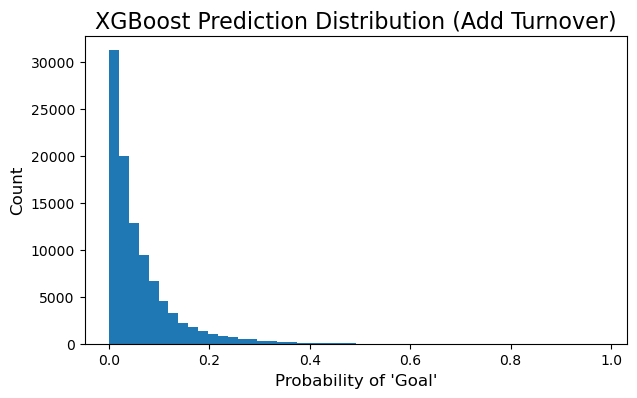

In [40]:
# Define the feature columns
add_to_cont = ['net_distance',  'net_angle', 'period', 'period_sec',
               'x_coord', 'y_coord', 'last_x_coord', 'last_y_coord',
               'dist_change', 'time_since_last']
add_to_bool = ['shooter_home', 'last_turnover_shot_end']

# Extract the training and test data
bool_cols = add_to_bool + list(new_feats.keys())[:-6]
X_train92, X_test92, y_train92, y_test92 = split_train_test_sets(data_df, add_to_cont, bool_cols, test_season=test_season)

xgb_add_to = XGBClassifier(**xgb_params)
xgb_add_to.fit(X_train92, y_train92)
d_add_to = {'name': 'Add Turnover',
             'y_test': y_test92,
             'model': xgb_add_to}

# Make predictions on the train and test sets
d_add_to['train_loss'] = log_loss(y_train92, d_add_to['model'].predict_proba(X_train92)[:, 1])
d_add_to['test_pred'] = d_add_to['model'].predict_proba(X_test92)[:, 1]
d_add_to['test_loss'] = log_loss(y_test92, d_add_to['test_pred'])
pred_classes = np.round(d_add_to['test_pred'], 0)
d_add_to['test_acc'] = 100 * (pred_classes == y_test92).sum() / y_test92.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(d_add_to['test_pred'], bins=50)
ax.set_title(f"XGBoost Prediction Distribution ({d_add_to['name']})", fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_add_to['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_add_to['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_add_to['test_acc']:4.2f}%")


## Shuffle All Data

Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.186
Test logloss on the NB model: 0.194
Test accuracy on the NB model: 94.30%


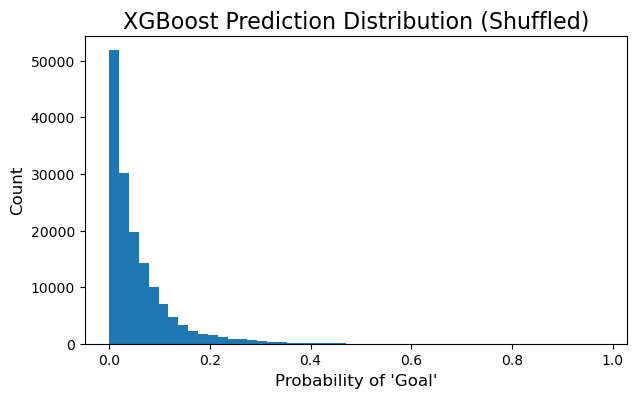

In [41]:
# Define the feature columns
shuffled_cont = ['net_distance',  'net_angle', 'period', 'period_sec',
                 'x_coord', 'y_coord', 'last_x_coord', 'last_y_coord',
                 'dist_change', 'time_since_last']
shuffled_bool = ['shooter_home']

# Extract the training and test data
bool_cols = shuffled_bool + list(new_feats.keys())[:-6]
X_train10, X_test10, y_train10, y_test10 = split_train_test_sets(data_df, shuffled_cont, bool_cols, shuffle=True)

xgb_shuffled = XGBClassifier(**xgb_params)
xgb_shuffled.fit(X_train10, y_train10)
d_shuffled = {'name': 'Shuffled',
              'y_test': y_test10,
              'model': xgb_shuffled}

# Make predictions on the train and test sets
d_shuffled['train_loss'] = log_loss(y_train10, d_shuffled['model'].predict_proba(X_train10)[:, 1])
d_shuffled['test_pred'] = d_shuffled['model'].predict_proba(X_test10)[:, 1]
d_shuffled['test_loss'] = log_loss(y_test10, d_shuffled['test_pred'])
pred_classes = np.round(d_shuffled['test_pred'], 0)
d_shuffled['test_acc'] = 100 * (pred_classes == y_test10).sum() / y_test10.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(d_shuffled['test_pred'], bins=50)
ax.set_title(f"XGBoost Prediction Distribution ({d_shuffled['name']})", fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_shuffled['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_shuffled['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_shuffled['test_acc']:4.2f}%")


## Shuffle After Split

Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.185
Test logloss on the NB model: 0.208
Test accuracy on the NB model: 93.83%


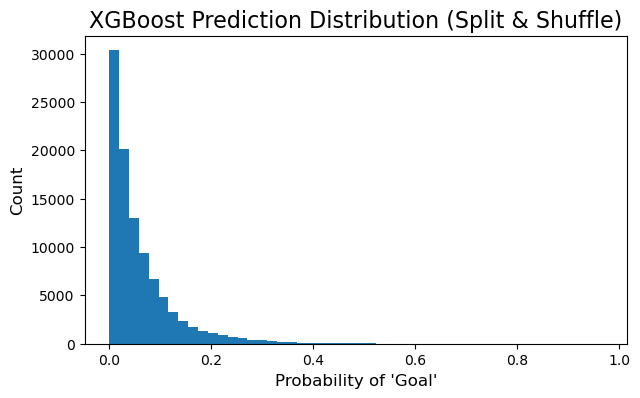

In [42]:
# Define the feature columns
shuffled2_cont = ['net_distance',  'net_angle', 'period', 'period_sec',
                  'x_coord', 'y_coord', 'last_x_coord', 'last_y_coord',
                  'dist_change', 'time_since_last']
shuffled2_bool = ['shooter_home']

# Extract the training and test data
bool_cols = shuffled2_bool + list(new_feats.keys())[:-6]
X_train102, X_test102, y_train102, y_test102 = split_train_test_sets(data_df, shuffled2_cont, bool_cols, test_season=test_season)
train_shuffle_inds = np.random.choice(y_train102.size, y_train102.size, replace=False)
X_train102 = X_train102[train_shuffle_inds, :]
y_train102 = y_train102[train_shuffle_inds]

xgb_shuffled2 = XGBClassifier(**xgb_params)
xgb_shuffled2.fit(X_train102, y_train102)
d_shuffled2 = {'name': 'Split & Shuffle',
              'y_test': y_test102,
              'model': xgb_shuffled2}

# Make predictions on the train and test sets
d_shuffled2['train_loss'] = log_loss(y_train102, d_shuffled2['model'].predict_proba(X_train102)[:, 1])
d_shuffled2['test_pred'] = d_shuffled2['model'].predict_proba(X_test102)[:, 1]
d_shuffled2['test_loss'] = log_loss(y_test102, d_shuffled2['test_pred'])
pred_classes = np.round(d_shuffled2['test_pred'], 0)
d_shuffled2['test_acc'] = 100 * (pred_classes == y_test102).sum() / y_test102.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(d_shuffled2['test_pred'], bins=50)
ax.set_title(f"XGBoost Prediction Distribution ({d_shuffled2['name']})", fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_shuffled2['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_shuffled2['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_shuffled2['test_acc']:4.2f}%")


### Effect of Shuffling
It appears that shuffling the data improves the performance, independent of whether it is split into training and test sets before or after shuffling. Therefore, it is likely there are some temporal patterns in the data that affect the training, and differ from season to season. Shuffling eliminates this sequential dependence. 

## Less Data

Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.180
Test logloss on the NB model: 0.193
Test accuracy on the NB model: 94.30%


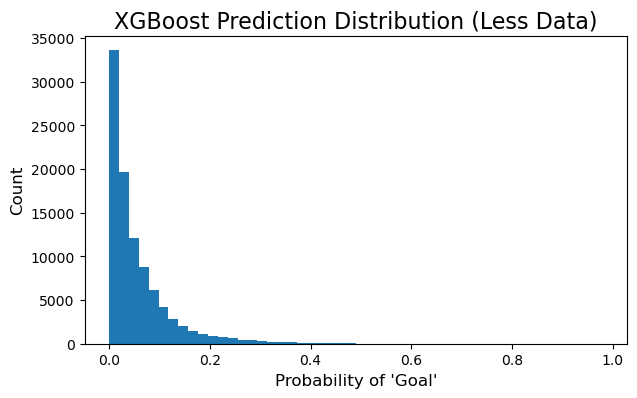

In [43]:
# Define the feature columns
less_data_cont = ['net_distance',  'net_angle', 'period', 'period_sec',
                  'x_coord', 'y_coord', 'last_x_coord', 'last_y_coord',
                  'dist_change', 'time_since_last']
less_data_bool = ['shooter_home']

# Extract the training and test data
bool_cols = less_data_bool + list(new_feats.keys())[:-6]
X_train11, X_test11, y_train11, y_test11 = split_train_test_sets(data_df, less_data_cont, bool_cols, test_season=2017)

xgb_less_data = XGBClassifier(**xgb_params)
xgb_less_data.fit(X_train11, y_train11)
d_less_data = {'name': 'Less Data',
               'y_test': y_test11,
               'model': xgb_less_data}

# Make predictions on the train and test sets
d_less_data['train_loss'] = log_loss(y_train11, d_less_data['model'].predict_proba(X_train11)[:, 1])
d_less_data['test_pred'] = d_less_data['model'].predict_proba(X_test11)[:, 1]
d_less_data['test_loss'] = log_loss(y_test11, d_less_data['test_pred'])
pred_classes = np.round(d_less_data['test_pred'], 0)
d_less_data['test_acc'] = 100 * (pred_classes == y_test11).sum() / y_test11.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(d_less_data['test_pred'], bins=50)
ax.set_title(f"XGBoost Prediction Distribution ({d_less_data['name']})", fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_less_data['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_less_data['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_less_data['test_acc']:4.2f}%")


## Weight Recent Samples More Heavily

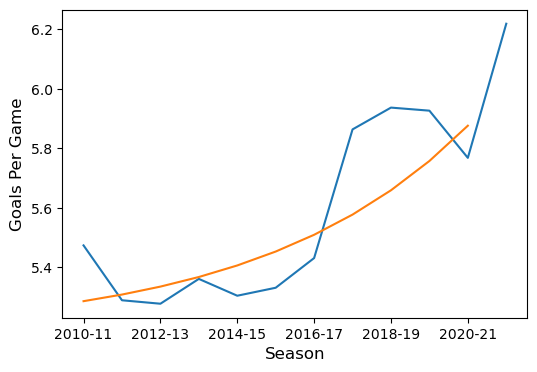

In [44]:
# Plot the way scoring has changed over the dataset
games_df = select_table(connection, 'games')
season_gb = games_df.groupby('season')
seasons = list(season_gb.groups.keys())
season_lbls = [f'{s[:4]}-{s[-2:]}' for s in seasons]
season_offset = int(seasons[-1][-4:]) - test_season
# print(season_lbls)
season_scores = season_gb.agg({'home_score':'sum','away_score':'sum'})
season_games = season_gb.game_id.count()
all_season_goals = np.array((season_scores.home_score + season_scores.away_score) / season_games)
season_goals = all_season_goals[:-season_offset]
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(all_season_goals, label='Actual')
ax.set_xlabel('Season', fontsize=12)
ax.set_xticks(np.arange(all_season_goals.size)[::2])
ax.set_xticklabels(season_lbls[::2])
ax.set_ylabel('Goals Per Game', fontsize=12)

# Fit an exponential to the data
# https://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly
x = np.arange(season_goals.size)
intercept = season_goals.min() - 0.1
y = season_goals - intercept
exp_fit = np.polyfit(x, np.log(y), 1)
fit_y = np.exp(exp_fit[1]) * np.exp(exp_fit[0] * x)
ax.plot(fit_y + intercept, label='Exponential Fit');


Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.182
Test logloss on the NB model: 0.208
Test accuracy on the NB model: 93.83%


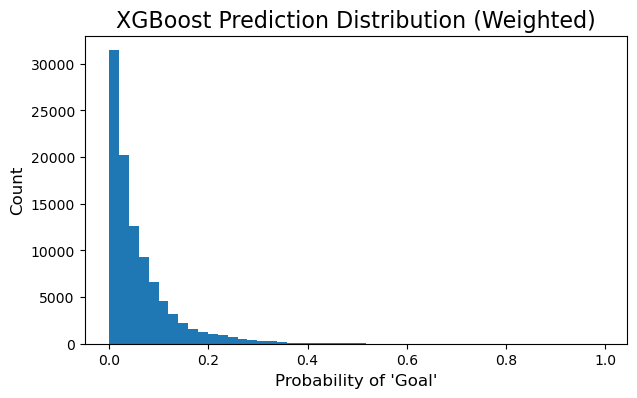

In [45]:
# Define the feature columns
weighted_cont = ['net_distance',  'net_angle', 'period', 'period_sec',
                 'x_coord', 'y_coord', 'last_x_coord', 'last_y_coord',
                 'dist_change', 'time_since_last']
weighted_bool = ['shooter_home']

# Extract the training and test data
bool_cols = weighted_bool + list(new_feats.keys())[:-6]
X_train12, X_test12, y_train12, y_test12 = split_train_test_sets(data_df, weighted_cont, bool_cols, test_season=test_season)

# Set the sample weights using the fit
shot_gb = data_df[data_df.season < test_season].groupby('season')
season_shots = shot_gb.game_id.count()
weights = np.repeat(fit_y, season_shots) + intercept

# Initialize the model
xgb_weighted = XGBClassifier(**xgb_params)
xgb_weighted.fit(X_train12, y_train12, sample_weight=weights)
d_weighted = {'name': 'Weighted',
              'y_test': y_test12,
              'model': xgb_weighted}

# Make predictions on the train and test sets
d_weighted['train_loss'] = log_loss(y_train12, d_weighted['model'].predict_proba(X_train12)[:, 1])
d_weighted['test_pred'] = d_weighted['model'].predict_proba(X_test12)[:, 1]
d_weighted['test_loss'] = log_loss(y_test12, d_weighted['test_pred'])
pred_classes = np.round(d_weighted['test_pred'], 0)
d_weighted['test_acc'] = 100 * (pred_classes == y_test12).sum() / y_test12.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(d_weighted['test_pred'], bins=50)
ax.set_title(f"XGBoost Prediction Distribution ({d_weighted['name']})", fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_weighted['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_weighted['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_weighted['test_acc']:4.2f}%")


## Optimal Combination

Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.188
Test logloss on the NB model: 0.194
Test accuracy on the NB model: 94.29%


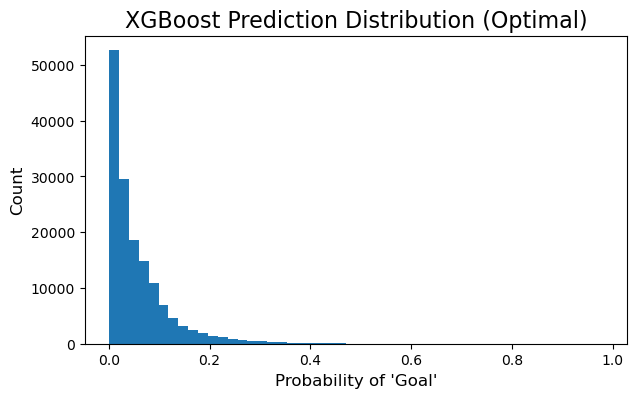

In [46]:
# Define the feature columns
optimal_cont = ['net_distance',  'net_angle', 'dist_change', 'angle_change',
                'shot_time', 'team_lead', 'time_since_last']
optimal_bool = ['shooter_home', 'last_same_team', 'forward_shot',
                'last_turnover_shot_end']

# Extract the training and test data
bool_cols = optimal_bool + list(new_feats.keys())[:3] + list(new_feats.keys())[-7:]
X_train13, X_test13, y_train13, y_test13 = split_train_test_sets(data_df, optimal_cont, bool_cols, shuffle=True)

xgb_optimal = XGBClassifier(**xgb_params)
xgb_optimal.fit(X_train13, y_train13)
d_optimal = {'name': 'Optimal',
             'y_test': y_test13,
             'model': xgb_optimal}

# Make predictions on the train and test sets
d_optimal['train_loss'] = log_loss(y_train13, d_optimal['model'].predict_proba(X_train13)[:, 1])
d_optimal['test_pred'] = d_optimal['model'].predict_proba(X_test13)[:, 1]
d_optimal['test_loss'] = log_loss(y_test13, d_optimal['test_pred'])
pred_classes = np.round(d_optimal['test_pred'], 0)
d_optimal['test_acc'] = 100 * (pred_classes == y_test13).sum() / y_test13.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(d_optimal['test_pred'], bins=50)
ax.set_title(f"XGBoost Prediction Distribution ({d_optimal['name']})", fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_optimal['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_optimal['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_optimal['test_acc']:4.2f}%")


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/marshineer/Hockey-Analytics/models/common_plot.py:69: RuntimeWarning: invalid value encountered in long_scalars
  true_frac[j] = (y_true_bin == 1).sum() / y_true_bin.size


The weighted calibration errors for the models are:
Baseline = 0.00243
No Shot Types = 0.00241
Game Time = 0.00243
Team Lead = 0.00244
Simple Priors = 0.00237
N-Players = 0.00255
No Redundant = 0.00223
Reduced = 0.00217
Add Position = 0.00232
Shuffled = 0.00151
Split & Shuffle = 0.00275
Less Data = 0.00166
Weighted = 0.00296
Optimal = 0.00142


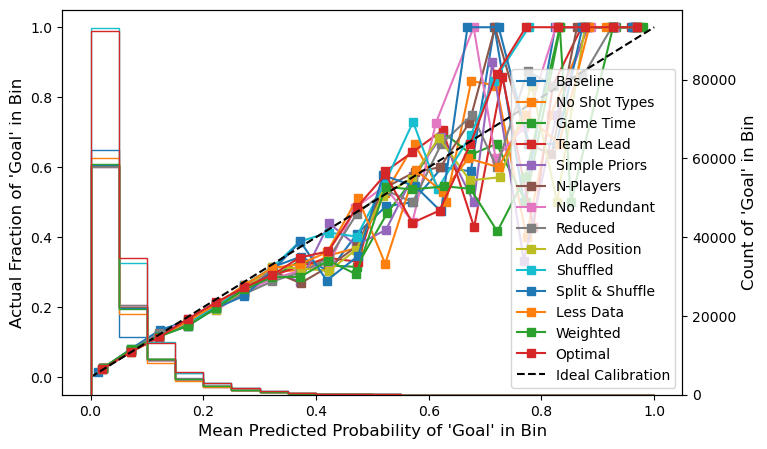

In [47]:
# Compare calibration curves
model_list = [d_baseline, d_no_shot_type, d_game_time, d_team_lead,
              d_simple_prior, d_n_players, d_no_redundant, d_reduced,
              d_add_pos, d_shuffled, d_shuffled2, d_less_data, d_weighted,
              d_optimal]
model_names = [model['name'] for model in model_list]
test_preds = [model['test_pred'] for model in model_list]
test_ys = [model['y_test'] for model in model_list]
mpl_objs = plot_calibration_curves(test_preds, test_ys, names=model_names,
                                   n_bins=20,  return_err=True, avg_curve=False,
                                   class1='Goal')
cal_errs = mpl_objs[-1]
print('The weighted calibration errors for the models are:')
for err, name in zip(cal_errs, model_names):
    print(f'{name} = {err:6.5f}')
    

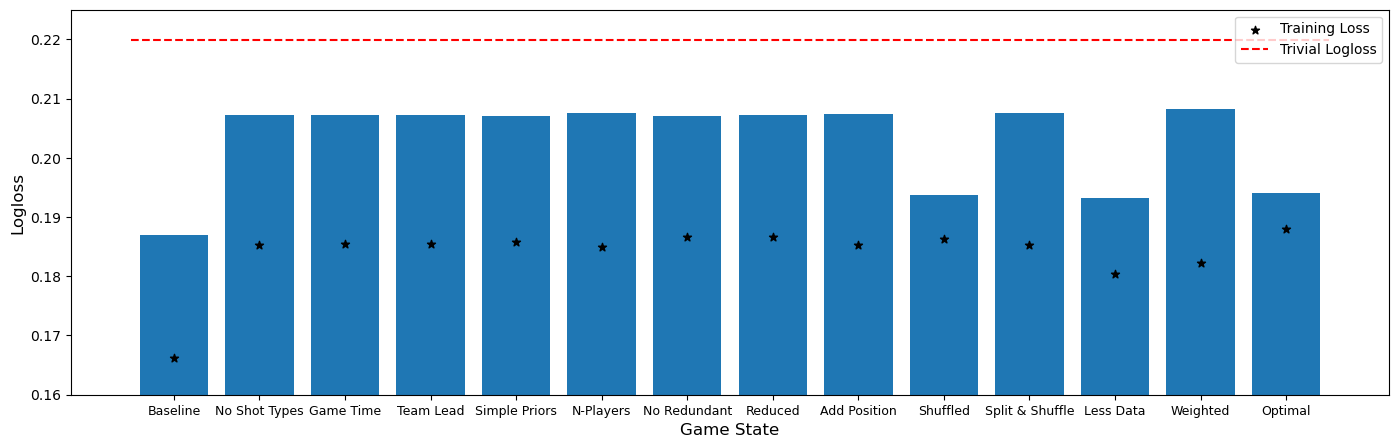

In [48]:
# Compare the model performances by logloss
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
width = 0.8
xs = np.arange(len(model_list)) + 0.5
test_loss = [model['test_loss'] for model in model_list]
train_loss = [model['train_loss'] for model in model_list]
ax.bar(xs, test_loss, width=width)
ax.scatter(xs, train_loss, color='k', marker='*', label='Training Loss')
ax.plot([0, len(model_list)], [dumb_loss, dumb_loss], 'r--', label='Trivial Logloss')
ax.set_xlabel('Game State', fontsize=12)
ax.set_xticks(xs)
ax.set_xticklabels(model_names, fontsize=9)
ax.set_ylabel('Logloss', fontsize=12)
ax.legend(loc=1)
ax.set_ylim([0.16, 0.225]);


# Conclusions

Evolving Hockey's model ("Baseline" in the plot above) incorrectly uses shot type data, which gives it an artificial boost in performance. For that reason, the second model listed (No Shot Types) is the true baseline for comparison in this analysis. As can be seen, most simplifications of the Evolving Hockey model do not affect the performance. This allowed me to eliminate many features, thus improving the computation speed. 

As noted in the introductory paragraphs, Evolving Hockey uses a subset of the data, training with data up to only the 2016-17 season, and testing with the 2017-18 season's data. This is likely because using any data following that results in a significant drop in performance, and they probably wished to present their model with the best possible results. If this change in model performance following the 2017-18 season is a true reflection of the underlying distributions, then may indicate a fundamental shift in the way goals are scored in the NHL. This seems like a reasonable conclusion, as the change coincides with an increase in the seasonal goal per game average. In this case, this is a development that I wish to study in a future analysis. 

Probably for a related reason, the only real improvement in performance is due to shuffling the data, or by using Evolving Hockey's reduced dataset. Therefore, what I consider the optimal model combines shuffling the data with a reduction of the input features, to improve training time.

One important note. Since I wish to use a version of expected goals to evaluate player performance, and eventually player impact, I will use this model to calculate the expected goals of all shots in the dataset. This means that I will train on the same data I am evaluating. I believe this is not a serious problem, as I will not be using this as a predictive measure, but rather an explanatory one, where I am evaluating the value of shots. When I eventually switch to making predictive models, I will generate new models with separate training and test sets.